# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Data loading
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


## Import packages and functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from scipy import stats
from scipy.stats import randint, shapiro
from scipy.interpolate import interp1d

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit
)

from sklearn.preprocessing import RobustScaler, LabelEncoder, robust_scale
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
    make_scorer
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import export_graphviz
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import LearningCurveDisplay

#import graphviz

## Description of the data 
- Checking for infinite numbers and NANs
- Checking whether the data is normally distributed
- Calculating correlation between features 
- Calculating p-values between features, to see if they significantly differ from each other

#### Checking for infinite numbers and NANs

In [3]:
# Checking for infinite numbers and NANs
def check_inf_and_nan(data, column):
    """Check if inf and nan values are present"""
    if np.isinf(data[f'{column}']).any() == True:
        return True
    if np.isnan(data[f'{column}']).any() == True:
        return True
    return False

#### Checking whether the data is normally distributed

c:\Users\michi\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


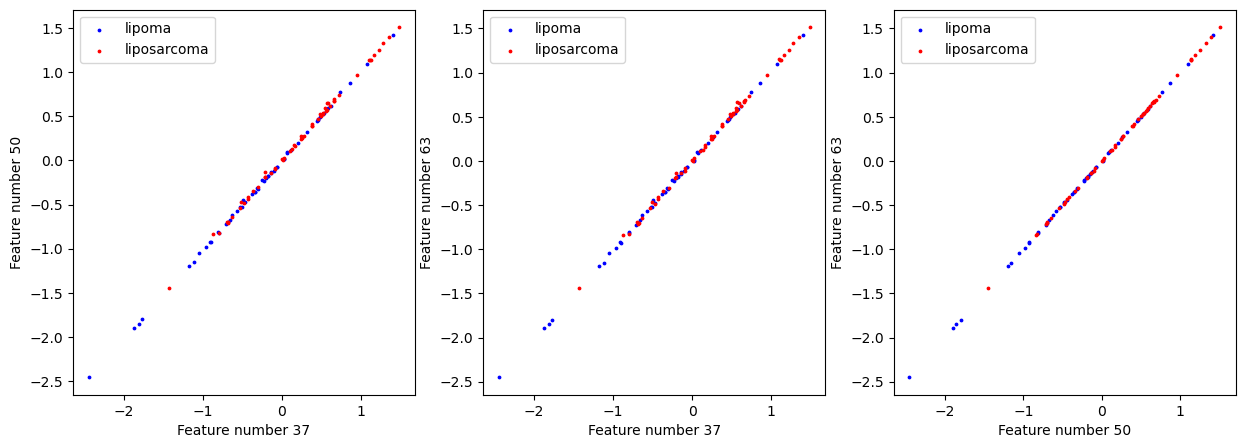

In [21]:
# Data loading
data = load_data()
X_scaled = robust_scale(data[data.columns[1:]])
data[data.columns[1:]] = X_scaled


def normal_distribution(data):
    '''
    This function checks the normal distribution of features in the dataset and performs statistical tests.
    '''
    lipoma = data[data['label'] == 'lipoma']
    liposarcoma = data[data['label'] == 'liposarcoma']

    normally_distributed_features = []  # List to store normally distributed features
    statistically_significant_features = []  # List to store statistically significant features
    statistically_significant_features_number = []  # List to store statistically significant features number

    # Loop through all features (excluding the label column)

    for feature_number, feature in enumerate(data.columns[1:], start=1):
        selected_feature_lipoma = lipoma[feature]
        selected_feature_liposarcoma = liposarcoma[feature]

        # Shapiro-Wilk test for normality
        stat_lipoma, p_lipoma = shapiro(selected_feature_lipoma)
        stat_liposarcoma, p_liposarcoma = shapiro(selected_feature_liposarcoma)

        if p_lipoma > 0.05 and p_liposarcoma > 0.05:
            # print(f"Feature '{feature}' is normally distributed")
            normally_distributed_features.append(feature)

            # Perform t-test for statistical significance
            stat, p_value = stats.ttest_ind(selected_feature_lipoma, selected_feature_liposarcoma)

            # Correct for multiple comparisons (Bonferroni correction)
            p_value *= len(normally_distributed_features)
                           
            if p_value < 0.05:
                # Save the feature number
                statistically_significant_features.append(feature)
                statistically_significant_features_number.append(feature_number)
    return lipoma, liposarcoma, normally_distributed_features, statistically_significant_features, statistically_significant_features_number

# call the function
[lipoma, liposarcoma,
 normally_distributed_features,
 statistically_significant_features,
 statistically_significant_features_number] = normal_distribution(data)

# Plot scatter of statistically significant features
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[1]], color='blue', label='lipoma', s=3)
axis[0].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[1]], color='red', label='liposarcoma', s=3)
axis[0].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[0].set_ylabel(f"Feature number {statistically_significant_features_number[1]}")
axis[0].legend()

axis[1].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[1].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[1].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[1].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[1].legend()

axis[2].scatter(lipoma[statistically_significant_features[1]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[2].scatter(liposarcoma[statistically_significant_features[1]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[2].set_xlabel(f"Feature number {statistically_significant_features_number[1]}")
axis[2].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[2].legend()

plt.show()

#### Calculating correlation between features

In [22]:
# Correlation between features
def correlation_features(data):
    '''
    This function calculates the correlation matrix between all features, seperately for the lipoma and liposarcoma groups. 
    For each feature combination (feature pair) it is determined if there is no correlation (>-0.5 and <0.5) in both groups.
    The amount of feature pairs without correlation and it's percentage is printed.
    '''
    data_lipoma = data[data['label'] == 'lipoma']
    data_lipoma.pop('label')
    corr_lipoma = data_lipoma.corr(method='pearson')
    no_corr_lipoma = (corr_lipoma>-0.5) & (corr_lipoma<0.5)
    
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    data_liposarcoma.pop('label')
    corr_liposarcoma = data_liposarcoma.corr(method='pearson')
    no_corr_liposarcoma = (corr_liposarcoma>-0.5) & (corr_liposarcoma<0.5)
    
    no_corr = no_corr_lipoma & no_corr_liposarcoma
    no_corr_count = 0
    for index, Series in no_corr.iterrows():
        for counts in Series:
            if counts == True:
                no_corr_count += 1

    no_corr_amount = (no_corr_count)/2
    feature_pairs = ((len(no_corr.index)-1)*len(no_corr.index))/2
    no_corr_percentage = no_corr_amount / feature_pairs * 100
    
    print(f'The amount of feature pairs without correlation is {no_corr_amount} out of {feature_pairs} feature pairs ({no_corr_percentage:5.4}%).')

correlation_features(data)

The amount of feature pairs without correlation is 92524.0 out of 121278.0 feature pairs (76.29%).


#### Calculating p-values 

In [4]:
def calculate_p_values(data):
    """Calculates the p_values for every feature in the data between the lipoma and liposarcoma group"""
    data_lipoma = data[data['label'] == 'lipoma']
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    p_values = pd.Series(0.0,index=data.columns)
    for column in data.columns:
        if any(isinstance(value, str) for value in data[f'{column}']):
            p_values = p_values.drop(f'{column}')
            continue
        stat, p = (stats.mannwhitneyu(data_lipoma[f'{column}'],data_liposarcoma[f'{column}'], axis=0))
        if p == 1.0:
            p_values = p_values.drop(f'{column}')
            continue
        p_values[f'{column}'] = p
    p_values = p_values.sort_values()
    return p_values

## Preprocessing of the data
- Anova feature selection??
- Other type of feature selection? 
- Removing features with variance = 0.0

#### Removing features with variance = 0.0

In [8]:

# Stap 1: Filter instellen op variantie = 0 (dus constante features)
constant_filter = VarianceThreshold(threshold=0.0)

# Stap 2: Fit en transform op je featurematrix
X_filtered = constant_filter.fit_transform(X)

# Stap 3: Optioneel - kolomnamen bijwerken
filtered_feature_names = X.columns[constant_filter.get_support()]

# Eventueel X terug omzetten naar DataFrame met originele index
X_filtered_df = pd.DataFrame(X_filtered, columns=filtered_feature_names, index=X.index)

print("Origineel aantal features:", X.shape[1])
print("Aantal na verwijderen constante features:", X_filtered_df.shape[1])

NameError: name 'X' is not defined

## Classifiers 
In this section, multiple classifiers are tested and their performance is evaluated using accuracy, sensitivity, specifity and ROC curves.

To train and test these classifiers, a definition is written to split the data.

#### Split data

In [5]:
def split_data(data,split=5,n=5):
    """ Docstring for split_data"""
    train_ratio = 1/split
    split_length_max = int(np.round(train_ratio * (data.shape[0]) * n))
    features = data.drop(columns=['label'])
    label = data['label']
    split_length_min = int(np.round(train_ratio * (data.shape[0]) * (n-1)))
    features_test = features[split_length_min:split_length_max]
    features_train = features.loc[~features.index.isin(features_test.index)]
    label_test = label[split_length_min:split_length_max]
    label_train = label.loc[~label.index.isin(label_test.index)]
    return features_train,features_test,label_train,label_test

#### Linear, quadratic and logistic regression
The three models are trained with the statistically significant features. 

LET OP HIER WORDT NOG VERKEERDE TRAIN_TEST_SPLIT GEBRUIKT!!!

In [6]:
# Select the statistically significant features
X = data[statistically_significant_features]
y = data['label'].apply(lambda x: 1 if x == 'liposarcoma' else 0)  # Convert labels to binary (0 for lipoma, 1 for liposarcoma)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
models = [SVC(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
for model_instance in models:
    # Fit the model on the training data
    model_instance.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model_instance.predict(X_test)
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model_instance.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

NameError: name 'statistically_significant_features' is not defined

#### Naive Bayes
There are multiple ways to compute a Naive Bayes. Here, the Gaussian method is applied. The other types of Naive Bayes are not possible
- nb_bernoulli = naive_bayes.BernoulliNB() --> not possible, since the features need to be binary
- nb_complement = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
- nb_categorical = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
- nb_multinomial = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

Naive Bayes is tested using multiple feature selection methods: 
- Based on p-values
- With Greedy forward feature selection

#### KNN classifier 
The KNN classifier is based on distance, so the data is scaled. 5 splits are performed and the optimal k is determined using 5-fold cross validation. ROC curves are made for each split to visualize the True Positive Rate and the False Positive Rate

## KNN with PCA


🔁 Split 1/5
  - Beste aantal PCA componenten op basis van de trainingsdata: 2
  - Optimale k gevonden via cross-validation op de trainingsset: 3
  - Test Accuracy: 0.5652
  - Test AUC: 0.5692

🔁 Split 2/5


KeyboardInterrupt: 

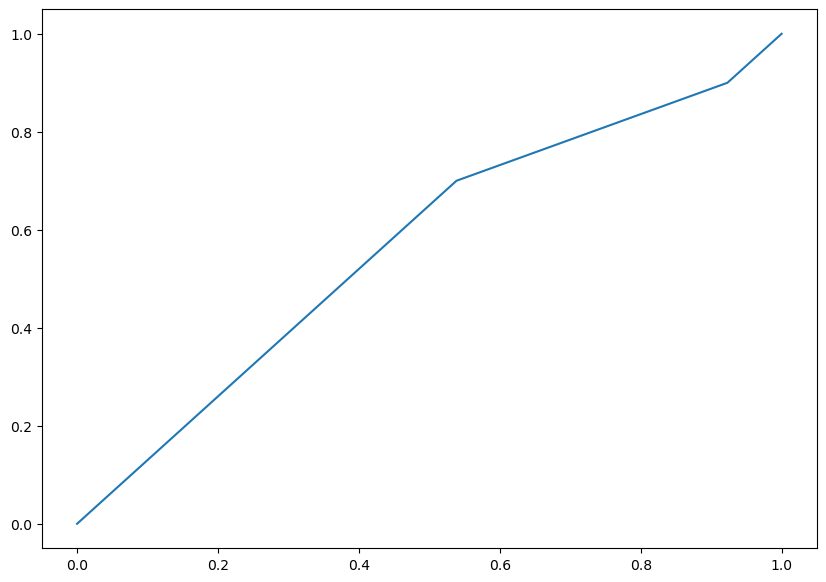

In [12]:
## proberen met een pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score


def pca_feature_selection(features_train, label_train, max_components=60):
    """PCA-selectie op basis van de trainingsdata."""
    accuracy = []
    
    # Loop over verschillende aantallen componenten
    for components in range(1, max_components + 1):
        # Maak de PCA transformator
        pca = PCA(n_components=components)
        
        # Maak een pipeline met PCA en KNN
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('pca', pca),
            ('knn', KNeighborsClassifier())
        ])
        
        # Voer cross-validation uit om de prestaties te meten
        scores = cross_val_score(pipeline, features_train, label_train, cv=5, scoring='accuracy')
        
        # Bewaar de gemiddelde accuracy voor dit aantal componenten
        accuracy.append(scores.mean())

    # Bepaal het aantal componenten met de hoogste gemiddelde accuracy
    best_n_components = np.argmax(accuracy) + 1  # +1 omdat de range start bij 1
    return best_n_components, accuracy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import copy

def run_pipeline_pca_knn(data, label='PCA + KNN', color='blue'):
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_acc = []
    k_values = list(range(1, 20, 2))

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    accuracy_per_split = []

    plt.figure(figsize=(10, 7))  # Voor ROC-curves

    for n in range(1, 6):
        print(f"\n🔁 Split {n}/5")

        features_train, features_test, label_train, label_test = split_data(data, split=5, n=n)

        best_n_components, accuracy = pca_feature_selection(features_train, label_train, max_components=60)
        print(f"  - Beste aantal PCA componenten op basis van de trainingsdata: {best_n_components}")
        accuracy_per_split.append(accuracy)

        cv_scores = []
        for k in k_values:
            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('pca', PCA(n_components=best_n_components)),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])
            scores = cross_val_score(pipeline, features_train, label_train, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())

        optimal_k = k_values[np.argmax(cv_scores)]
        print(f"  - Optimale k gevonden via cross-validation op de trainingsset: {optimal_k}")

        final_pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=best_n_components)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k))
        ])
        final_pipeline.fit(features_train, label_train)

        y_pred = final_pipeline.predict(features_test)
        y_proba = final_pipeline.predict_proba(features_test)[:, 1]
        acc = accuracy_score(label_test, y_pred)
        auc_score = roc_auc_score(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)

        print(f"  - Test Accuracy: {acc:.4f}")
        print(f"  - Test AUC: {auc_score:.4f}")

        all_acc.append(acc)
        all_auc.append(auc_score)

        fpr, tpr, _ = roc_curve(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr += interp_tpr
        all_fpr.append(fpr)
        all_tpr.append(tpr)

        plt.plot(fpr, tpr, label=f'Split {n} (AUC = {auc_score:.2f})')

    mean_tpr /= 5
    mean_auc = auc(mean_fpr, mean_tpr)

    # Plot Mean ROC
    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over 5 Splits (PCA + KNN)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n🎯 Gemiddelde prestaties over 5 splits:")
    print(f"- Gemiddelde Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print(f"- Gemiddelde AUC:      {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

    # Plot accuracy per aantal PCA componenten per split
    plt.figure(figsize=(10, 6))
    for n in range(5):
        plt.plot(range(1, len(accuracy_per_split[n]) + 1), accuracy_per_split[n], label=f'Split {n+1}')
    plt.xlabel('Aantal PCA Componenten')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Aantal PCA Componenten per Split')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'label': label,
        'mean_fpr': mean_fpr.copy(),
        'mean_tpr': mean_tpr.copy(),
        'all_auc': all_auc.copy(),
        'color': color
    }

results_pca_knn = run_pipeline_pca_knn(data, label='PCA + KNN', color='blue')



## KNN with 20 lowest p-values


🔁 Split 1/5
  - Optimal k: 11
  - Test Accuracy: 0.6522
  - Test AUC: 0.7692

🔁 Split 2/5
  - Optimal k: 9
  - Test Accuracy: 0.6522
  - Test AUC: 0.7538

🔁 Split 3/5
  - Optimal k: 11
  - Test Accuracy: 0.6087
  - Test AUC: 0.6962

🔁 Split 4/5
  - Optimal k: 9
  - Test Accuracy: 0.6957
  - Test AUC: 0.7538

🔁 Split 5/5
  - Optimal k: 9
  - Test Accuracy: 0.6522
  - Test AUC: 0.7579


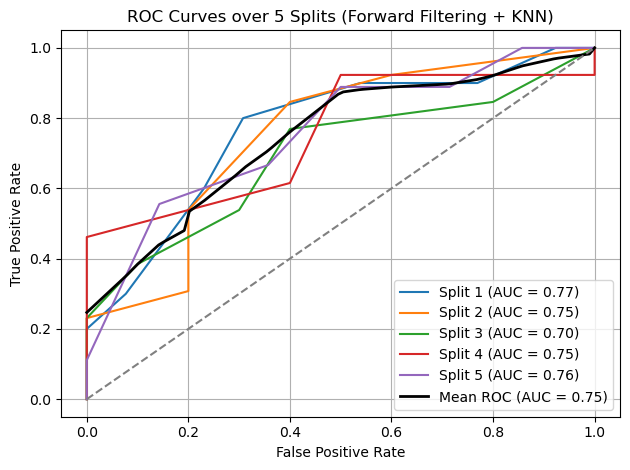


🎯 Gemiddelde prestaties over 5 splits:
- Gemiddelde Accuracy: 0.6522 ± 0.0275
- Gemiddelde AUC:      0.7462 ± 0.0257


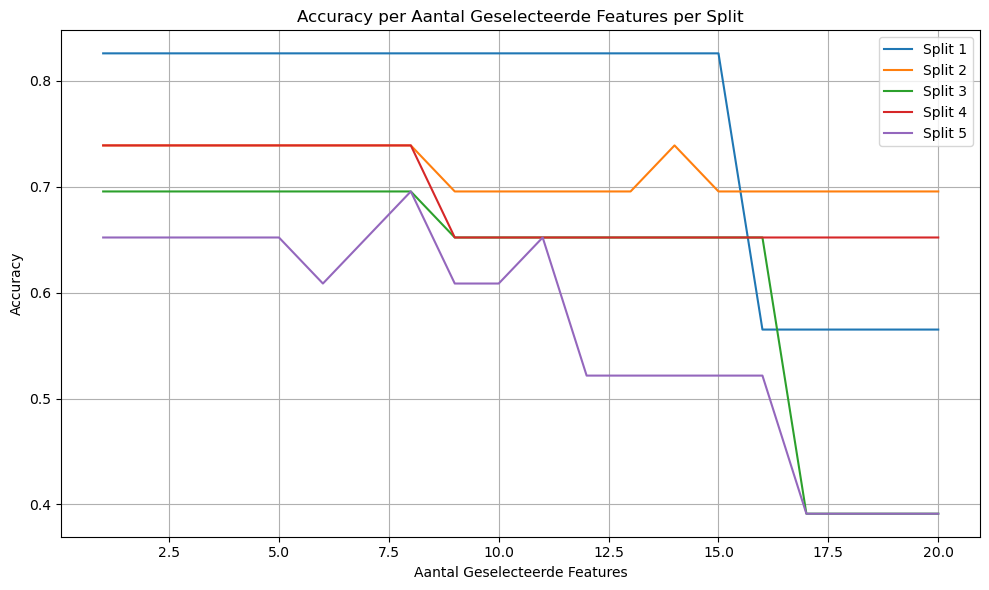

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

def select_top_pvalue_features(data, num_features=20):
    """Selecteert de top X features met laagste p-waarde"""
    p_values = calculate_p_values(data)

    # Drop 'label' als die er nog in zit
    p_values = p_values.drop(labels='label', errors='ignore')

    # Selecteer de top X features
    top_features = p_values.sort_values().index[:num_features].tolist()
    return top_features

# Functie om de pipeline uit te voeren met forward filtering en te evalueren
def run_pipeline_with_forward_filtering_and_accuracy_plot(data, model):
    # Verzamel de ROC-curve resultaten
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_acc = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    k_values = list(range(1, 20, 2))
    
    # Lijst om de accuracy voor verschillende aantallen features per split op te slaan
    accuracy_per_split_vs_features = []

    # Loop over de 5 splits
    for n in range(1, 6):
        print(f"\n🔁 Split {n}/5")

        # 1. Split data
        features_train, features_test, label_train, label_test = split_data(data, split=5, n=n)
        train_data = features_train.copy()
        train_data['label'] = label_train

        best_features = select_top_pvalue_features(train_data, num_features=20)

        # Lijst om accuracy per aantal features op te slaan
        accuracy_per_split = []

        # Test verschillende aantallen geselecteerde features (van 1 tot n geselecteerde features)
        for i in range(1, len(best_features) + 1):
            selected_features_subset = best_features[:i]
            features_train_subset = features_train[selected_features_subset]
            features_test_subset = features_test[selected_features_subset]

            # Train en test het model
            model.fit(features_train_subset, label_train)
            label_pred = model.predict(features_test_subset)

            acc = accuracy_score(label_test, label_pred)
            accuracy_per_split.append(acc)

        # Voeg de accuracies voor deze split toe aan de lijst
        accuracy_per_split_vs_features.append(accuracy_per_split)

        # 3. Optimaliseer k via cross-validation op de trainset
        cv_scores = []
        for k in k_values:
            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])
            scores = cross_val_score(pipeline, features_train[best_features], label_train, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())

        optimal_k = k_values[np.argmax(cv_scores)]
        print(f"  - Optimal k: {optimal_k}")

        # 4. Bouw en train finale pipeline
        final_pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k))
        ])
        final_pipeline.fit(features_train[best_features], label_train)

        # 5. Evaluatie op testset
        y_pred = final_pipeline.predict(features_test[best_features])
        y_proba = final_pipeline.predict_proba(features_test[best_features])[:, 1]
        acc = accuracy_score(label_test, y_pred)
        auc_score = roc_auc_score(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)

        print(f"  - Test Accuracy: {acc:.4f}")
        print(f"  - Test AUC: {auc_score:.4f}")

        all_acc.append(acc)
        all_auc.append(auc_score)

        # ROC curve per split
        fpr, tpr, _ = roc_curve(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr += interp_tpr
        all_fpr.append(fpr)
        all_tpr.append(tpr)

        plt.plot(fpr, tpr, label=f'Split {n} (AUC = {auc_score:.2f})')

    # Gemiddelde ROC berekenen
    mean_tpr /= 5
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over 5 Splits (Forward Filtering + KNN)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gemiddelde prestaties
    print("\n🎯 Gemiddelde prestaties over 5 splits:")
    print(f"- Gemiddelde Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print(f"- Gemiddelde AUC:      {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

    # Visualiseer de accuracy tegen het aantal geselecteerde features
    plt.figure(figsize=(10, 6))

    # Plot de accuracy tegen het aantal geselecteerde features voor elke split
    for n in range(5):
        plt.plot(range(1, len(accuracy_per_split_vs_features[n]) + 1),
                 accuracy_per_split_vs_features[n], label=f'Split {n+1}')

    plt.xlabel('Aantal Geselecteerde Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Aantal Geselecteerde Features per Split')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

# Gebruik de functie met een model, bijvoorbeeld KNeighborsClassifier
model = KNeighborsClassifier()
pipeline_results_forwardtwenty = run_pipeline_with_forward_filtering_and_accuracy_plot(data, model)



## KNN with forward filtering, amount of features selected based on highest accuracy


🔁 Split 1/5
🔍 Split 1 top feature: PREDICT_original_sf_volume_2.5D
  - Geselecteerde features voor Split 1: ['PREDICT_original_sf_volume_2.5D']
  - Optimal k: 9
  - Test Accuracy: 0.8261
  - Test AUC: 0.8846

🔁 Split 2/5
🔍 Split 2 top feature: PREDICT_original_sf_volume_2.5D
  - Geselecteerde features voor Split 2: ['PREDICT_original_sf_volume_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_tf_Gabor_mean_F0.2_A0.79', 'PREDICT_original_tf_Gabor_mean_F0.2_A0.0', 'PREDICT_original_tf_Gabor_mean_F0.05_A0.0', 'PREDICT_original_tf_Gabor_mean_F0.5_A0.79', 'PREDICT_original_tf_Gabor_energy_F0.2_A0.0']
  - Optimal k: 19
  - Test Accuracy: 0.6522
  - Test AUC: 0.8192

🔁 Split 3/5
🔍 Split 3 top feature: PREDICT_original_sf_volume_2.5D
  - Geselecteerde features voor Split 3: ['PREDICT_original_sf_volume_2.5D']
  - Optimal k: 9
  - Test Accuracy: 0.6957
  - Test AUC: 0.7500

🔁 Split 4/5
🔍 Split 4 top feature: 

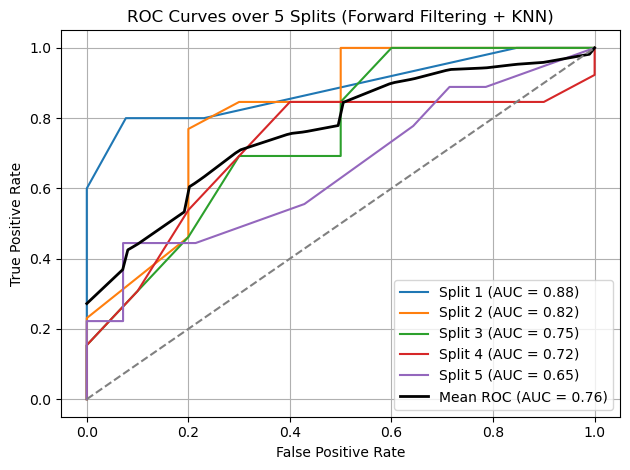


🎯 Gemiddelde prestaties over 5 splits:
- Gemiddelde Accuracy: 0.6783 ± 0.0852
- Gemiddelde AUC:      0.7648 ± 0.0801


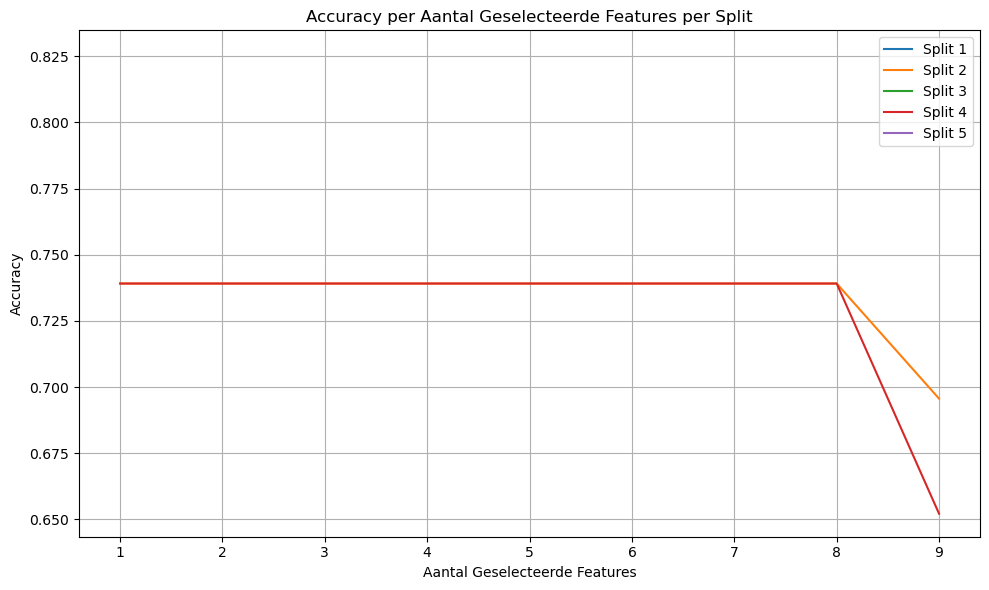

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

# Functie voor forward filtering (zoals je hebt gedefinieerd)
def forward_filtering(features_train, model):
    p_values = calculate_p_values(features_train)

    data_p_values = pd.DataFrame(p_values, columns=['p_value'])
    data_p_values['feature'] = data_p_values.index
    data_p_values = data_p_values.reset_index(drop=True)

    selected_features = []
    best_features = []
    best_score = 0

    accuracies = []
    specificities = []
    sensitivities = []
    added_scores = []

    for i in range(min(150, len(data_p_values))):
        selected_features.append(data_p_values['feature'][i])

        X = data[selected_features]
        y = data['label']

        # Gebruik cross-validation voor accuracyscore
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
        scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(accuracy_score))

        acc = np.mean(scores)

        accuracies.append(acc)
        sensitivities.append(None)     # Worden niet meer berekend
        specificities.append(None)
        added_scores.append(acc)

        if acc > best_score:
            best_score = acc
            best_features = list(selected_features)

    return best_features, accuracies, sensitivities, specificities, added_scores

# Functie om de pipeline uit te voeren met forward filtering en te evalueren
def run_pipeline_with_forward_filtering_and_accuracy_plot(data, model):
    # Verzamel de ROC-curve resultaten
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_acc = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    k_values = list(range(1, 20, 2))
    
    # Lijst om de accuracy voor verschillende aantallen features per split op te slaan
    accuracy_per_split_vs_features = []

    # Loop over de 5 splits
    for n in range(1, 6):
        print(f"\n🔁 Split {n}/5")

        # 1. Split data
        features_train, features_test, label_train, label_test = split_data(data, split=5, n=n)
        train_data = features_train.copy()
        train_data['label'] = label_train
        
        best_features, accuracies, sensitivities, specificities, added_scores = forward_filtering(train_data, model)
        if best_features:
            print(f"🔍 Split {n} top feature: {best_features[0]}")
        # Print de geselecteerde features voor deze split
        print(f"  - Geselecteerde features voor Split {n}: {best_features}")

        # Lijst om accuracy per aantal features op te slaan
        accuracy_per_split = []

        # Test verschillende aantallen geselecteerde features (van 1 tot n geselecteerde features)
        for i in range(1, len(best_features) + 1):
            selected_features_subset = best_features[:i]
            features_train_subset = features_train[selected_features_subset]
            features_test_subset = features_test[selected_features_subset]

            # Train en test het model
            model.fit(features_train_subset, label_train)
            label_pred = model.predict(features_test_subset)

            acc = accuracy_score(label_test, label_pred)
            accuracy_per_split.append(acc)

        # Voeg de accuracies voor deze split toe aan de lijst
        accuracy_per_split_vs_features.append(accuracy_per_split)

        # 3. Optimaliseer k via cross-validation op de trainset
        cv_scores = []
        for k in k_values:
            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])
            scores = cross_val_score(pipeline, features_train[best_features], label_train, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())

        optimal_k = k_values[np.argmax(cv_scores)]
        print(f"  - Optimal k: {optimal_k}")

        # 4. Bouw en train finale pipeline
        final_pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k))
        ])
        final_pipeline.fit(features_train[best_features], label_train)

        # 5. Evaluatie op testset
        y_pred = final_pipeline.predict(features_test[best_features])
        y_proba = final_pipeline.predict_proba(features_test[best_features])[:, 1]
        acc = accuracy_score(label_test, y_pred)
        auc_score = roc_auc_score(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)

        print(f"  - Test Accuracy: {acc:.4f}")
        print(f"  - Test AUC: {auc_score:.4f}")

        all_acc.append(acc)
        all_auc.append(auc_score)

        # ROC curve per split
        fpr, tpr, _ = roc_curve(label_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr += interp_tpr
        all_fpr.append(fpr)
        all_tpr.append(tpr)

        plt.plot(fpr, tpr, label=f'Split {n} (AUC = {auc_score:.2f})')

    # Gemiddelde ROC berekenen
    mean_tpr /= 5
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over 5 Splits (Forward Filtering + KNN)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gemiddelde prestaties
    print("\n🎯 Gemiddelde prestaties over 5 splits:")
    print(f"- Gemiddelde Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print(f"- Gemiddelde AUC:      {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

    # Visualiseer de accuracy tegen het aantal geselecteerde features
    plt.figure(figsize=(10, 6))

    # Plot de accuracy tegen het aantal geselecteerde features voor elke split
    for n in range(5):
        plt.plot(range(1, len(accuracy_per_split_vs_features[n]) + 1),
                 accuracy_per_split_vs_features[n], label=f'Split {n+1}')

    plt.xlabel('Aantal Geselecteerde Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Aantal Geselecteerde Features per Split')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gebruik de functie met een model, bijvoorbeeld KNeighborsClassifier
model = KNeighborsClassifier()
run_pipeline_with_forward_filtering_and_accuracy_plot(data, model)




## KNN with greedy


🔁 Split 1/5
  - Geselecteerde features: ['PREDICT_original_sf_volume_2.5D', 'PREDICT_original_tf_Gabor_energy_F0.05_A0.0', 'PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D']
  - Optimal k: 13
  - Test Accuracy: 0.6522
  - Test AUC:      0.7923

🔁 Split 2/5
  - Geselecteerde features: ['PREDICT_original_sf_area_max_2.5D', 'PREDICT_or

KeyboardInterrupt: 

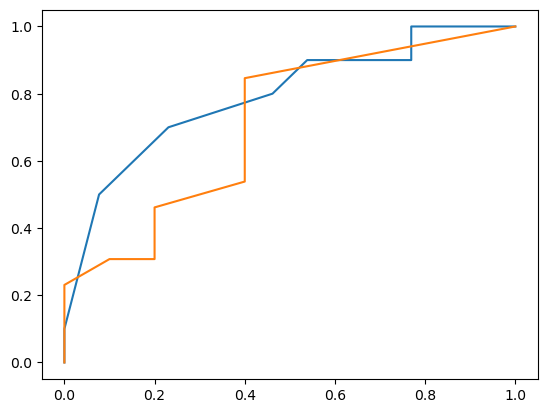

In [22]:
def greedy_forward_selection(data, model, max_features=20):
    """Greedy forward feature selection based on accuracy."""
    all_features = data.drop(columns='label').columns.tolist()
    selected_features = []
    remaining_features = all_features.copy()

    best_score = 0
    scores_per_step = []

    for _ in range(min(max_features, len(remaining_features))):
        best_feature = None
        best_temp_score = 0

        for feature in remaining_features:
            temp_features = selected_features + [feature]
            X = data[temp_features]
            y = data['label']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            score = accuracy_score(y_test, preds)

            if score > best_temp_score:
                best_temp_score = score
                best_feature = feature

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            scores_per_step.append(best_temp_score)
        else:
            break

    return selected_features, scores_per_step

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def run_pipeline_with_greedy_selection(data, model, max_features=20):
    all_acc = []
    all_auc = []
    k_values = list(range(1, 20, 2))
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for n in range(1, 6):
        print(f"\n🔁 Split {n}/5")

        # 1. Split
        X_train, X_test, y_train, y_test = split_data(data, split=5, n=n)

        train_data = X_train.copy()
        train_data['label'] = y_train

        # 2. Greedy Feature Selection
        best_features, greedy_scores = greedy_forward_selection(train_data, model, max_features=max_features)
        print(f"  - Geselecteerde features: {best_features}")

        X_train_sel = X_train[best_features]
        X_test_sel = X_test[best_features]

        # 3. Zoek beste k via CV
        cv_scores = []
        for k in k_values:
            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])
            scores = cross_val_score(pipeline, X_train_sel, y_train, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())

        optimal_k = k_values[np.argmax(cv_scores)]
        print(f"  - Optimal k: {optimal_k}")

        # 4. Final model
        final_pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k))
        ])
        final_pipeline.fit(X_train_sel, y_train)

        # 5. Evaluatie
        y_pred = final_pipeline.predict(X_test_sel)
        y_proba = final_pipeline.predict_proba(X_test_sel)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)

        print(f"  - Test Accuracy: {acc:.4f}")
        print(f"  - Test AUC:      {auc_score:.4f}")

        all_acc.append(acc)
        all_auc.append(auc_score)

        fpr, tpr, _ = roc_curve(y_test.map({'lipoma': 0, 'liposarcoma': 1}), y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr += interp_tpr
        plt.plot(fpr, tpr, label=f'Split {n} (AUC = {auc_score:.2f})')

    # Gemiddelde ROC
    mean_tpr /= 5
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over 5 Splits (Greedy + KNN)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n🎯 Gemiddelde prestaties over 5 splits:")
    print(f"- Gemiddelde Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print(f"- Gemiddelde AUC:      {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

run_pipeline_with_greedy_selection(data, KNeighborsClassifier(), max_features=20)


## plot mean roc curves verschillende feature selection methods 

In [50]:
def plot_multiple_mean_roc_curves(pipelines_results):
    """
    pipelines_results = list of dicts with keys:
    - 'label': name of the pipeline
    - 'mean_fpr': shared FPR (np.linspace)
    - 'mean_tpr': averaged TPR
    - 'all_auc': list of AUCs for std deviation
    - 'color': color for the curve
    """

    plt.figure(figsize=(10, 7))

    for result in pipelines_results:
        mean_auc = auc(result['mean_fpr'], result['mean_tpr'])
        std_auc = np.std(result['all_auc'])

        plt.plot(result['mean_fpr'], result['mean_tpr'],
                 label=f"{result['label']} (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
                 linewidth=2,
                 color=result.get('color', None))

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Vergelijking van Mean ROC Curves per Pipeline')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_multiple_mean_roc_curves([pipeline_results_forwardtwenty, results_pca_knn])

for result in [results_pca_knn, pipeline_results_forwardtwenty]:
    print(f"{result['label']}: {auc(result['mean_fpr'], result['mean_tpr']):.3f} ± {np.std(result['all_auc']):.3f}")


PCA + KNN: 0.594 ± 0.078


TypeError: 'NoneType' object is not subscriptable

## Random Forest

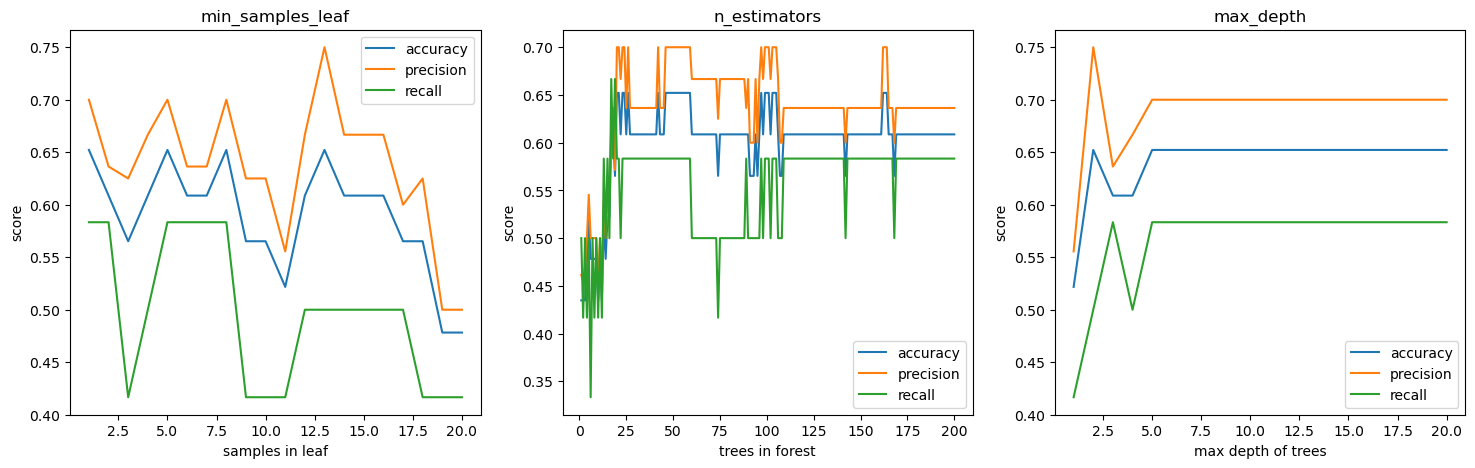

In [11]:
def test_hyperparameter(parameter,value_max):
    accuracy = []
    precision = []
    recall = []
    values = []
    for value in range(1,(value_max+1)):
        model_test = RandomForestClassifier(**{parameter: value}, random_state=42)
        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        values.append(value)
    return accuracy,precision,recall,values

def plot_testing_values(axis, title,xlabel,ylabel,values,accuracy,precision,recall):
    axis.plot(values,accuracy, label='accuracy')
    axis.plot(values,precision, label='precision')
    axis.plot(values,recall, label='recall')
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    axis.legend()

data = load_data()

data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']

split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]

transformer = RobustScaler().fit(features_train)
features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)

fig, axis = plt.subplots(1,3, figsize=(18,5))
accuracy1, precision1, recall1, values1 = test_hyperparameter('min_samples_leaf', 20)
plot_testing_values(axis[0], 'min_samples_leaf','samples in leaf','score', values1, accuracy1, precision1, recall1)
accuracy2, precision2, recall2, values2 = test_hyperparameter('n_estimators', 200)
plot_testing_values(axis[1], 'n_estimators','trees in forest','score', values2, accuracy2, precision2, recall2)
accuracy3, precision3, recall3, values3 = test_hyperparameter('max_depth', 20)
plot_testing_values(axis[2], 'max_depth','max depth of trees','score', values3, accuracy3, precision3, recall3)

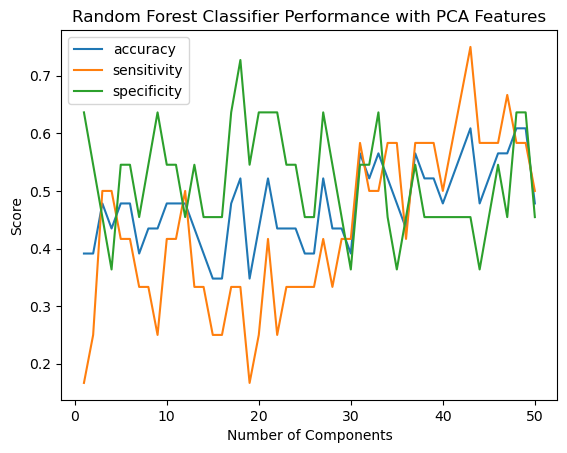

In [12]:
def pca_feature_selection(data, model_test):
    accuracy = []
    precision = []
    recall = []
    added_scores = []
    for components in range(1, 51, 1):
        #split data to get even groups
        data_lipoma_pca = data[data['label'] == 'lipoma']
        data_liposarcoma_pca = data[data['label'] == 'liposarcoma']
        #split train and test set using split_data
        split_lipoma_pca = split_data(data_lipoma_pca)
        split_liposarcoma_pca = split_data(data_liposarcoma_pca)
        features_train, features_test, label_train, label_test = [
        pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
        ]
        #scale data using robust scaler
        transformer = RobustScaler().fit(features_train)
        features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
        features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
        #PCA fit on train set, then same PCA on test set
        pca = PCA(n_components=components)
        pca_transform = pca.fit_transform(features_train)
        features_train = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
        features_test = pca.transform(features_test)
        features_test = pd.DataFrame(data=features_test,columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])

        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        acc = accuracy_score(label_test, label_pred)
        sen = recall_score(label_test, label_pred, pos_label='liposarcoma')
        spe = recall_score(label_test, label_pred, pos_label='lipoma')
        accuracy.append(acc)
        precision.append(sen)
        recall.append(spe)
        added_scores.append(acc+sen+spe)
    return added_scores, accuracy, precision, recall

# Plot components vs accuracy, precision and recall in 1 figure
model = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=100, max_depth=10)
add_scores, accuracy, precision, recall = pca_feature_selection(data, model)
fig, axis = plt.subplots()
axis.plot(range(1, 51, 1), accuracy, label='accuracy')
axis.plot(range(1, 51, 1), precision, label='sensitivity')
axis.plot(range(1, 51, 1), recall, label='specificity')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Random Forest Classifier Performance with PCA Features')
plt.legend()
plt.show()

In [13]:
import warnings

warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
def forward_filtering(data, model):
    # forward selection method
    # sort the features by p-value
    p_values = calculate_p_values(data)

    data_p_values = pd.DataFrame(p_values, columns=['p_value'])
    data_p_values['feature'] = data_p_values.index
    data_p_values = data_p_values.reset_index(drop=True)

    # Make a loop adding features one by one and check the accuracy of the model
    features = []

    accuracies = []
    specificities = []
    sensitivities = []
    added_scores = []
    # Loop through features
    for feature in range(0, 150):
        features.append(data_p_values['feature'][feature])
        features_train, features_test, label_train, label_test = train_test_split(data[features], data['label'], test_size=0.2, random_state=41, stratify=data['label'])
        #add robust scaling
        transformer = RobustScaler().fit(features_train)
        features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
        features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
        # Store accuracy scores for the current feature
        param_dist = {'n_estimators': randint(1,150),
            'max_depth': randint(2,10),
            'min_samples_leaf': randint(3,10)}

        model.fit(features_train, label_train)
        label_pred = model.predict(features_test)
        acc = accuracy_score(label_test, label_pred)
        sen = recall_score(label_test, label_pred, pos_label='liposarcoma')
        spe = recall_score(label_test, label_pred, pos_label='lipoma')
        accuracies.append(acc)
        specificities.append(spe)
        sensitivities.append(sen)
        added_scores.append(acc+sen+spe)
    return accuracies, specificities, sensitivities, added_scores

Text(0.5, 1.0, 'Sensitivity')

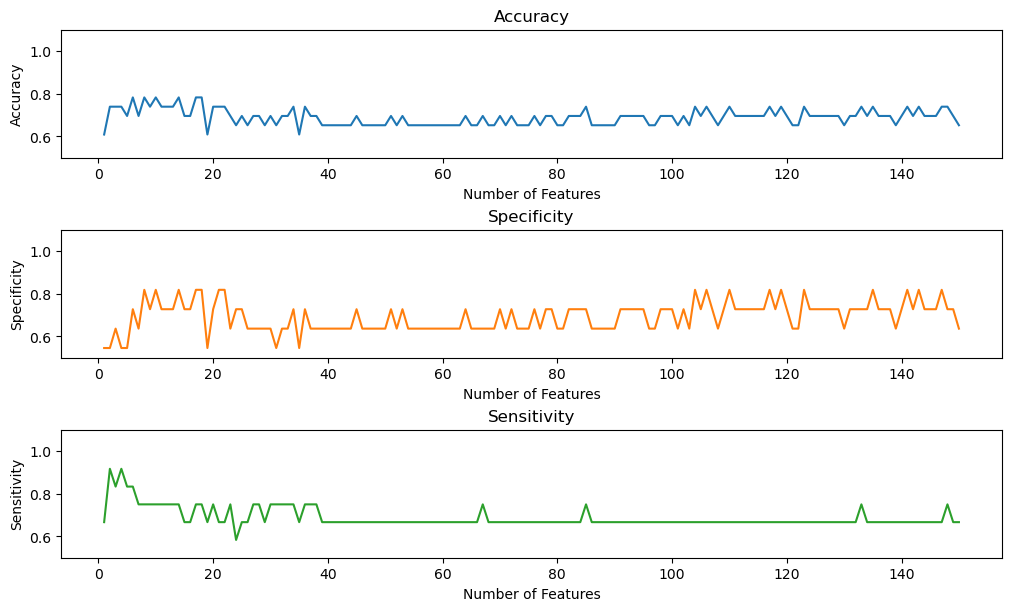

In [45]:
model = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=75, random_state=42)
accuracy_df, specificity_df, sensitivity_df, added_scores= forward_filtering(data, model)
fig, axis = plt.subplots(3, figsize=(10,6), constrained_layout=True)
axis[0].plot(range(1, len(accuracy_df)+1), accuracy_df, label='accuracy', color='tab:blue')
axis[0].set_xlabel('Number of Features')
axis[0].set_ylabel('Accuracy')
axis[0].set_ylim(0.5, 1.1)
axis[0].set_title('Accuracy')

axis[1].plot(range(1, len(specificity_df)+1), specificity_df, label='specificity', color='tab:orange')
axis[1].set_xlabel('Number of Features')
axis[1].set_ylabel('Specificity')
axis[1].set_ylim(0.5, 1.1)
axis[1].set_title('Specificity')

axis[2].plot(range(1, len(sensitivity_df)+1), sensitivity_df, label='sensitivity', color='tab:green')
axis[2].set_xlabel('Number of Features')
axis[2].set_ylabel('Sensitivity')
axis[2].set_ylim(0.5, 1.1)
axis[2].set_title('Sensitivity')

In [18]:
def learning_curve_plot(model, best_hyper_params, data_used):
    if model == SVC:
        model = model(random_state=42, **best_hyper_params, kernel='rbf')
    else:
        model = model(random_state=42, **best_hyper_params)
    X = data_used.drop(columns='label')
    transformer = RobustScaler().fit(X)
    data_used_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
    data_used = pd.concat([data_used_scaled, data_used['label']], axis=1)
    fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
    common_params = {
        "X": data_used.drop(columns='label'),
        "y": data_used['label'],
        "train_sizes": np.linspace(0.1, 1.0, 20),
        "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }
    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {model.__class__.__name__}")

Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.8695652173913043, Specificity: 0.9090909090909091, Sensitivity: 0.8333333333333334
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.7391304347826086, Specificity: 0.5833333333333334, Sensitivity: 0.9090909090909091
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.7391304347826086, Specificity: 0.7272727272727273, Sensitivity: 0.75
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 75}
Accuracy: 0.782608695652174, Specificity: 0.8333333333333334, Sensitivity: 0.7272727272727273
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.6956521739130435, Specificity: 0.9090909090909091, Sensitivity: 0.5
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 9, 'n_estimators': 103}
Accuracy: 0.5555555555555556, Specificity: 0.8888888888888888,

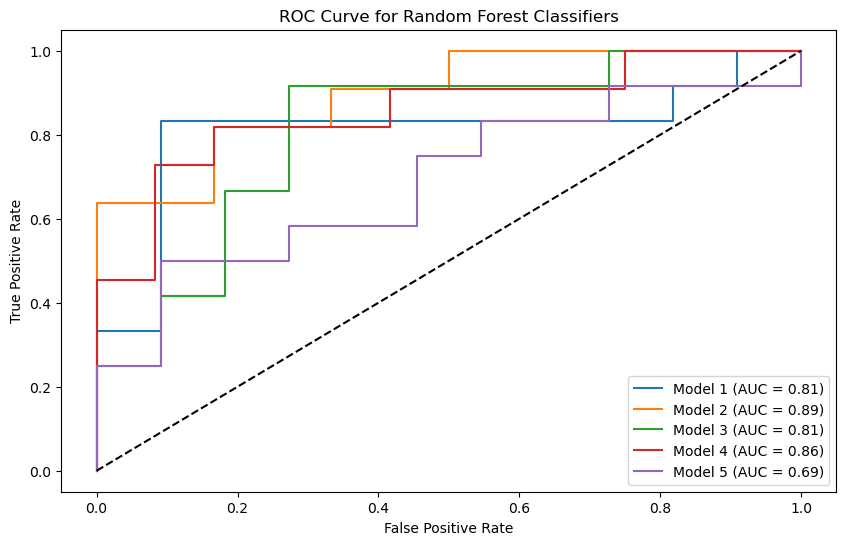

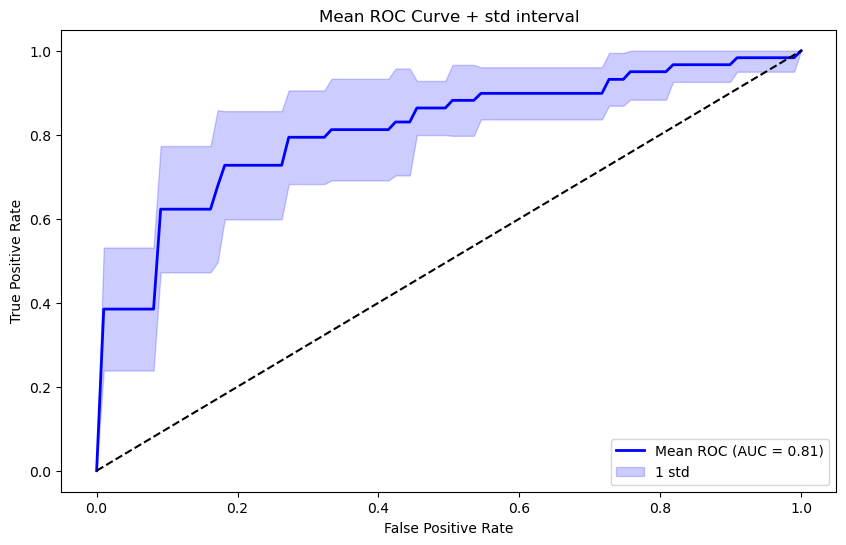

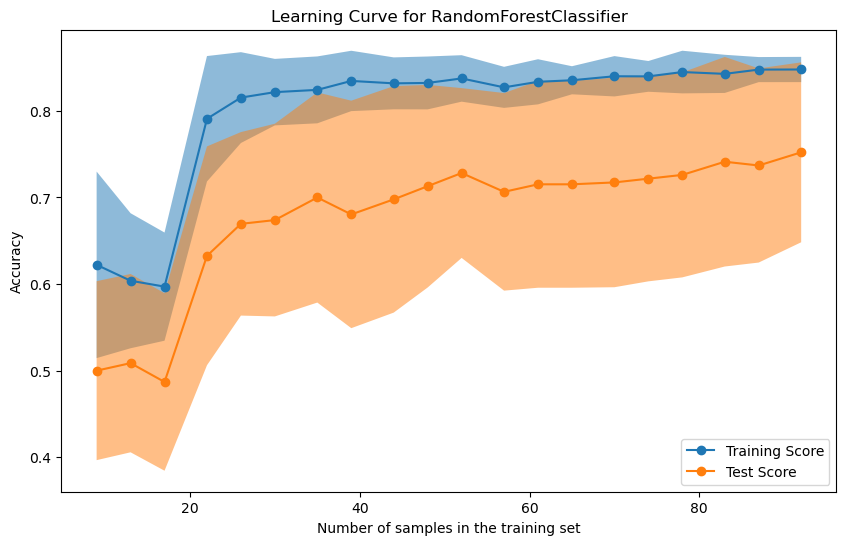

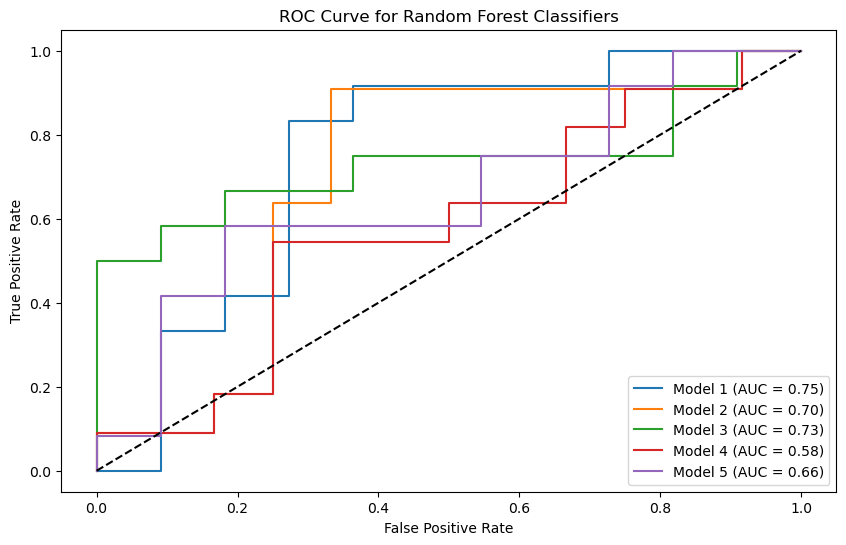

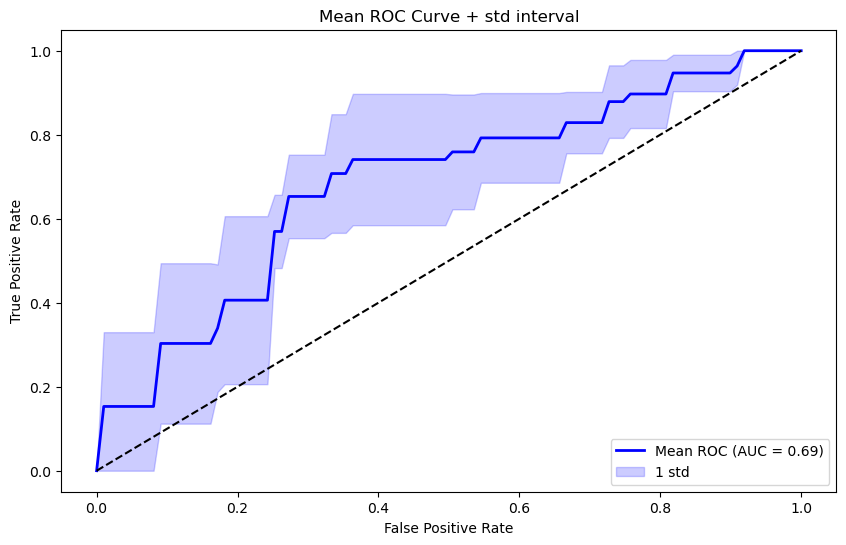

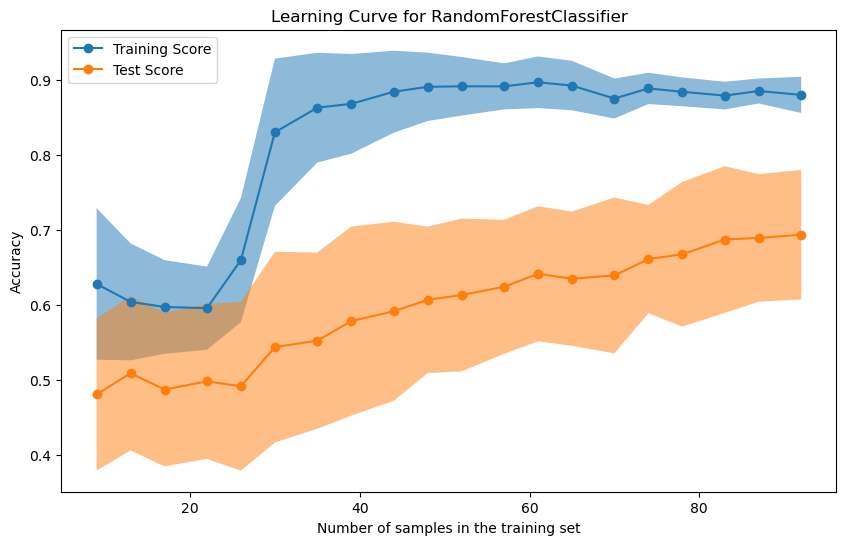

In [19]:
def random_forest_classifier(data, selection):
    param_dist = {'n_estimators': randint(1,150),
                  'max_depth': randint(2,10),
                  'min_samples_leaf': randint(5,10)}

    model = RandomForestClassifier(random_state=42)

    rand_search = RandomizedSearchCV(model, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5,
                                     random_state=42)

    n = 5
    accuracy = []
    specificity = []
    sensitivity = []
    all_roc = np.linspace(0, 1, 100)
    roc_list = []
    best_rf_complete = []
    best_hyper_params = []
    features = []
    plt.figure(figsize=(10, 6))
    for i in range(1,n+1):
        split_lipoma = split_data(data_lipoma, n, i)
        split_liposarcoma = split_data(data_liposarcoma, n, i)
        features_train, features_test, label_train, label_test = [
            pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
            ]
        train_data_rf = pd.concat([features_train, label_train], axis=1)
        if selection == 'forward filtering':
            model_select = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=75, random_state=42)
            accuracies, specificies, sensitivities, added_scores = forward_filtering(train_data_rf, model_select)
            best_features = added_scores.index(max(added_scores))+1
            features.append(best_features)
            p_values = calculate_p_values(train_data_rf)
            p_values_used = p_values[:best_features].index
            columns_to_keep = list(p_values_used)
            transformer = RobustScaler().fit(features_train)
            features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
            features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
            features_train = features_train[columns_to_keep]
            features_test = features_test[columns_to_keep]
        elif selection == 'pca':
            model_test = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=100, max_depth=10)
            add_scores, accuracy, sensitivity, specificity = pca_feature_selection(train_data_rf, model_test)
            best_pca = add_scores.index(max(add_scores))+1
            features.append(best_pca)
            transformer = RobustScaler().fit(features_train)
            features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
            features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
            pca = PCA(n_components=best_pca)
            pca_transform = pca.fit_transform(features_train)
            features_train = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
            features_test = pca.transform(features_test)
            features_test = pd.DataFrame(data=features_test,columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])

        rand_search.fit(features_train, label_train)
        best_rf = rand_search.best_estimator_
        best_rf_complete.append(best_rf)
        best_hyper_params.append(rand_search.best_params_)
        print('Best hyperparameters:',  rand_search.best_params_)

        label_pred = best_rf.predict(features_test)
        label_prob = best_rf.predict_proba(features_test)[:, 1]

        accuracy.append(accuracy_score(label_test, label_pred))
        specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
        sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

        fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

        interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
        interp_roc[0] = 0
        roc_list.append(interp_roc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest Classifiers')
    plt.legend(loc='lower right')

    roc_array = np.array(roc_list)
    mean_roc = np.mean(roc_array, axis=0)
    std_roc = np.std(roc_array, axis=0)
    ci_upper = np.minimum(mean_roc + 1 * std_roc, 1)
    ci_lower = np.maximum(mean_roc - 1 * std_roc, 0)
    mean_auc = auc(all_roc, mean_roc)
    roc_tuple = (mean_roc, std_roc, ci_upper, ci_lower, mean_auc)

    plt.figure(figsize=(10, 6))
    plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
    plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='1 std')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve + std interval')
    plt.legend(loc='lower right')
    return best_rf_complete, best_hyper_params, features, roc_tuple

# for i in range(1):
#     tree = best_rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=features_train.columns,  
#                                filled=True,  
#                                max_depth=3, 
#                                impurity=True, 
#                                proportion=False)
#     graph = graphviz.Source(dot_data)
#     display(graph)

best_rf_complete, best_hyper_params, feature_amount, roc_ff_rf = random_forest_classifier(data, 'forward filtering')

p_values = calculate_p_values(data)
p_values_used = p_values[:feature_amount[1]].index
columns_to_keep = list(p_values_used) + ['label']
data_used = data[columns_to_keep]
learning_curve_plot(RandomForestClassifier, best_hyper_params[1], data_used)

best_rf_complete, best_hyper_params, pca_comp, roc_pca_rf = random_forest_classifier(data, 'pca')

pca = PCA(n_components=pca_comp[0])
pca_transform = pca.fit_transform(data.drop(columns='label'))
data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
data_pca['label'] = data['label'].values
learning_curve_plot(RandomForestClassifier, best_hyper_params[0], data_pca)

--------------------------------------

#### Support Vector Machine


In [20]:
split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]
train_data_svm = pd.concat([features_train, label_train], axis=1)
p_values = calculate_p_values(train_data_svm)
p_values_used = p_values[:20].index
columns_to_keep = list(p_values_used)
transformer = RobustScaler().fit(features_train)
features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
features_train = features_train[columns_to_keep]
features_test = features_test[columns_to_keep]

# Train different SVM models with different kernels
kernels = ['poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(features_train, label_train)
    y_pred = model.predict(features_test)
    accuracy = accuracy_score(label_test, y_pred)
    print(f"Training model: {model.__class__.__name__}, Kernel: {kernel}, Model Accuracy: {accuracy:.4f}")

Training model: SVC, Kernel: poly, Model Accuracy: 0.5217
Training model: SVC, Kernel: rbf, Model Accuracy: 0.6087
Training model: SVC, Kernel: sigmoid, Model Accuracy: 0.4348


Best hyperparameters: {'C': 129.15496650148827, 'gamma': 0.0001}
Accuracy: 0.8695652173913043, Specificity: 1.0, Sensitivity: 0.75
Best hyperparameters: {'C': 0.774263682681127, 'gamma': 10.0}
Accuracy: 0.8260869565217391, Specificity: 0.8333333333333334, Sensitivity: 0.8181818181818182
Best hyperparameters: {'C': 0.2782559402207124, 'gamma': 2.782559402207126}
Accuracy: 0.6956521739130435, Specificity: 0.6363636363636364, Sensitivity: 0.75
Best hyperparameters: {'C': 0.2782559402207124, 'gamma': 2.782559402207126}
Accuracy: 0.782608695652174, Specificity: 0.9166666666666666, Sensitivity: 0.6363636363636364
Best hyperparameters: {'C': 5.994842503189409, 'gamma': 0.21544346900318845}
Accuracy: 0.6956521739130435, Specificity: 0.9090909090909091, Sensitivity: 0.5
Best hyperparameters: {'C': 46.41588833612777, 'gamma': 0.001291549665014884}
Accuracy: 0.5217391304347826, Specificity: 0.0, Sensitivity: 1.0
Best hyperparameters: {'C': 0.774263682681127, 'gamma': 0.21544346900318845}
Accuracy

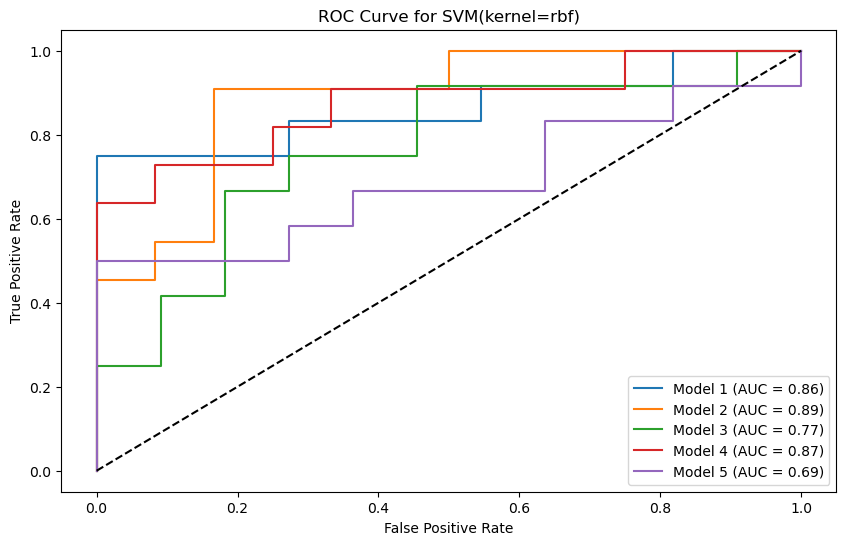

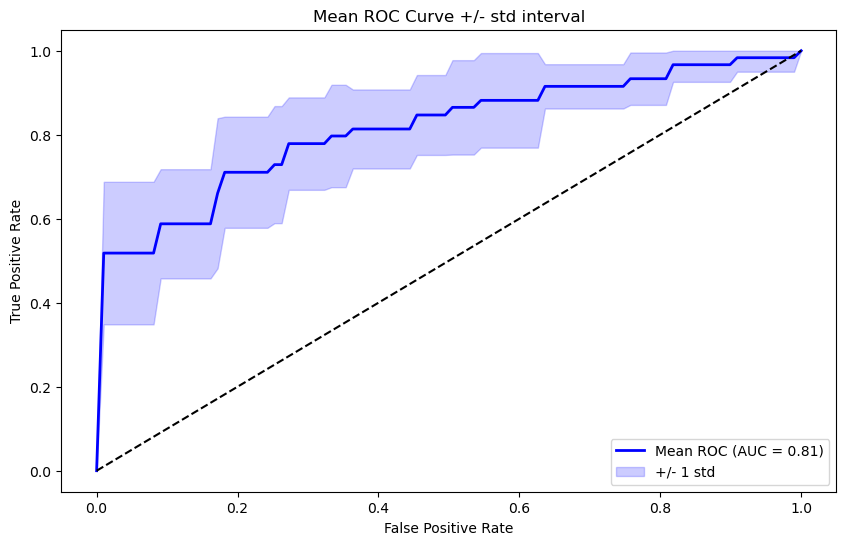

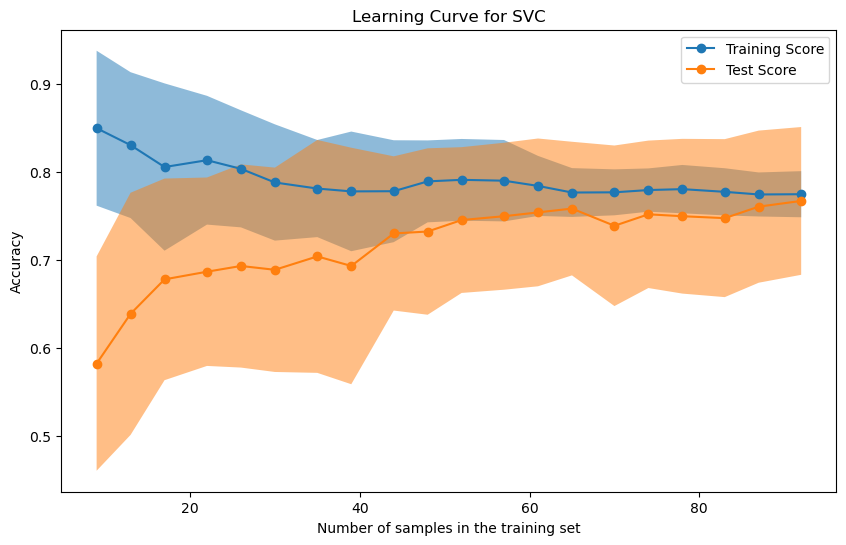

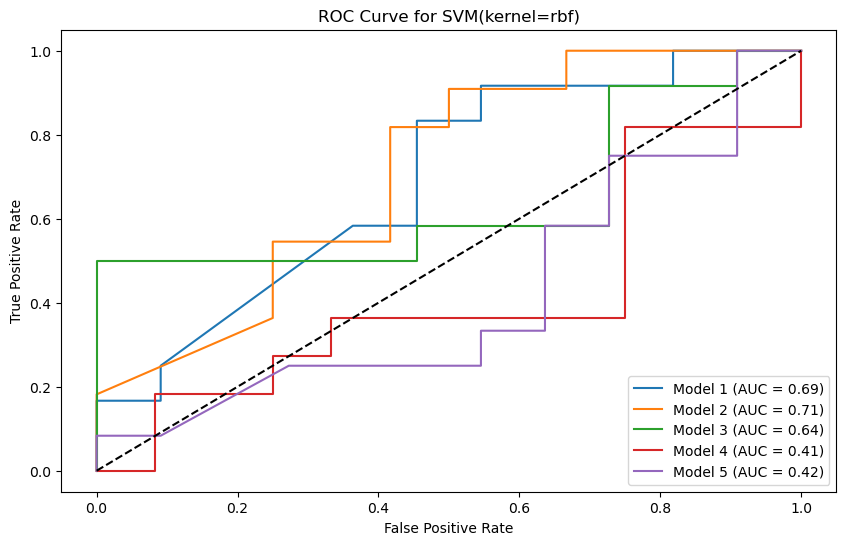

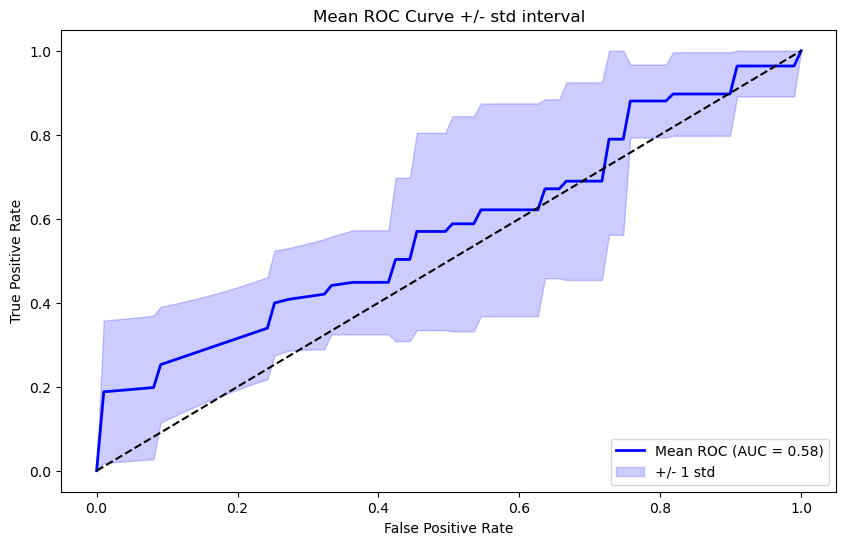

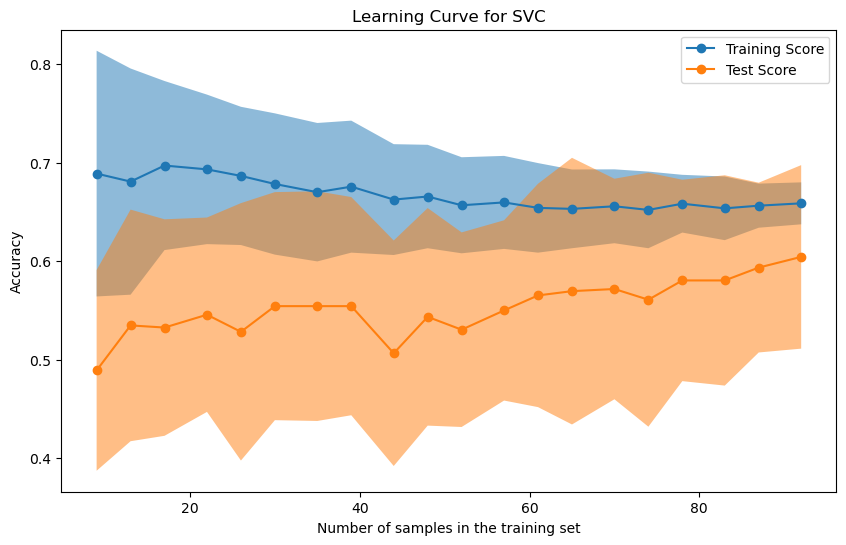

In [21]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
def svm_classifier(data, selection):
    param_dist = {'gamma': np.logspace(-4, 1, 10), 'C' : np.logspace(-1, 3, 10)}

    rand_search_SVC = GridSearchCV(SVC(kernel='rbf', random_state=42, probability=True), 
                                    param_grid = param_dist, 
                                    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42))
    
    n = 5
    accuracy = []
    specificity = []
    sensitivity = []
    all_roc = np.linspace(0, 1, 100)
    roc_list = []
    best_rf_complete = []
    best_hyper_params = []
    features = []
    plt.figure(figsize=(10, 6))
    for i in range(1,n+1):
        split_lipoma = split_data(data_lipoma, n, i)
        split_liposarcoma = split_data(data_liposarcoma, n, i)
        features_train, features_test, label_train, label_test = [
            pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
            ]
        train_data_rf = pd.concat([features_train, label_train], axis=1)
        if selection == 'forward filtering':
            train_data_rf = pd.concat([features_train, label_train], axis=1)
            model_select = SVC(kernel='rbf', random_state=42)
            accuracies, specificies, sensitivities, added_scores = forward_filtering(train_data_rf, model_select)
            best_features = added_scores.index(max(added_scores))+1
            features.append(best_features)
            p_values = calculate_p_values(train_data_rf)
            p_values_used = p_values[:best_features].index
            columns_to_keep = list(p_values_used)
            transformer = RobustScaler().fit(features_train)
            features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
            features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
            features_train = features_train[columns_to_keep]
            features_test = features_test[columns_to_keep]
        elif selection == 'pca':
            model_test = SVC(kernel='rbf', random_state=42)
            add_scores, accuracy, sensitivity, specificity = pca_feature_selection(data, model_test)
            best_pca = add_scores.index(max(add_scores))+1
            features.append(best_pca)
            transformer = RobustScaler().fit(features_train)
            features_train = pd.DataFrame(transformer.transform(features_train), columns=features_train.columns, index=features_train.index)
            features_test = pd.DataFrame(transformer.transform(features_test), columns=features_test.columns, index=features_test.index)
            pca = PCA(n_components=best_pca)
            pca_transform = pca.fit_transform(features_train)
            features_train = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
            features_test = pca.transform(features_test)
            features_test = pd.DataFrame(data=features_test,columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
        
        rand_search_SVC.fit(features_train, label_train)
        best_rf = rand_search_SVC.best_estimator_
        print('Best hyperparameters:',  rand_search_SVC.best_params_)
        best_rf_complete.append(best_rf)
        best_hyper_params.append(rand_search_SVC.best_params_)
        label_pred = best_rf.predict(features_test)
        label_prob = best_rf.predict_proba(features_test)[:, 1]

        accuracy.append(accuracy_score(label_test, label_pred))
        specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
        sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

        fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

        interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
        interp_roc[0] = 0
        roc_list.append(interp_roc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SVM(kernel=rbf)')
    plt.legend(loc='lower right')

    roc_array = np.array(roc_list)
    mean_roc = np.mean(roc_array, axis=0)
    std_roc = np.std(roc_array, axis=0)
    ci_upper = np.minimum(mean_roc + 1 * std_roc, 1)
    ci_lower = np.maximum(mean_roc - 1 * std_roc, 0)
    mean_auc = auc(all_roc, mean_roc)
    roc_tuple = (mean_roc, std_roc, ci_upper, ci_lower, mean_auc)

    plt.figure(figsize=(10, 6))
    plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
    plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='+/- 1 std')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve +/- std interval')
    plt.legend(loc='lower right')
    return best_rf_complete, best_hyper_params, features, roc_tuple

best_rf_complete, best_hyper_params, feature_amount, roc_ff_svm = svm_classifier(data, 'forward filtering')

p_values = calculate_p_values(data)
p_values_used = p_values[:feature_amount[1]].index
columns_to_keep = list(p_values_used) + ['label']
data_used = data[columns_to_keep]
learning_curve_plot(SVC, best_hyper_params[1], data_used)

best_rf_complete, best_hyper_params, pca_comp, roc_pca_svm = svm_classifier(data, 'pca')

pca = PCA(n_components=pca_comp[1])
pca_transform = pca.fit_transform(data.drop(columns='label'))
data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
data_pca['label'] = data['label'].values
learning_curve_plot(SVC, best_hyper_params[1], data_pca)